In this notebook, we devise a method to identify very coarse niche types in mouse brain. 

Main brain components:

- Cortex, full of neurons like excitatory
- Striatum, full of inhibitory neurons.
- White matter, full of oligodendrocytes who generate myelin,

Microglia are immune cells in the brain

Astrocytes are everywhere but more close to boundaries,

We can assume more macrophages in the old mice

We can use this dataset to compare niches from different ages

endothelial cells = surrounds the blood vessels

In [1]:
%load_ext autoreload
%autoreload 2

In [173]:
import anndata as ad
import numpy as np
import pandas as pd

from rich import print
import os

import scvi

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from scib_metrics.benchmark import Benchmarker
from scvi.strip_metrics import SpatialAnalysis

from anndata import AnnData

In [3]:
scvi.settings.seed = 34

Global seed set to 34


In [4]:
# !ls /home/labs/nyosef/Collaboration/SpatialDatasets/merfish/BrainAgingSpatialAtlas_MERFISH

!ls /home/nathanlevy/Data/BrainAgingSpatialAtlas_MERFISH/

adata_MERFISH_24w.h5ad
adata_scvi_merfish4w.h5ad
BrainAgingSpatialAtlas_MERFISH_24weeks.h5ad
BrainAgingSpatialAtlas_MERFISH_4weeks.h5ad
BrainAgingSpatialAtlas_MERFISH.h5ad
BrainAgingSpatialAtlas_MERFISH.ipynb


In [5]:
plots = False

In [124]:
data_dirs = {
    "VIZGEN_Liver": [
        "/home/nathanlevy/Data/Liver_VIZGEN/",
        "liver-joint-scvi3-annotated.h5ad",
    ],
    "MERFISH_Brain": [
        # "/home/labs/nyosef/Collaboration/SpatialDatasets/merfish/BrainAgingSpatialAtlas_MERFISH/",
        "/home/nathanlevy/Data/BrainAgingSpatialAtlas_MERFISH/",
        "adata_scvi_merfish4w.h5ad",
    ],
    "NANOSTRING_Lung": [
        "/home/nathanlevy/Data/",
        "nanostring_bis_finished_hotspot_densities.h5ad",
    ],
}

In [125]:
# data_dir = "/home/nathanlevy/Data/BrainAgingSpatialAtlas_MERFISH/"
# data_file = "adata_scvi_merfish4w.h5ad"

data_dir, data_file = data_dirs["MERFISH_Brain"]

data_file_name = os.path.splitext(data_file)[0]
print(data_file_name)

adata_scvi_merfish4w

In [126]:
path_to_save = os.path.join("checkpoints", data_file_name)
os.makedirs(path_to_save, exist_ok=True)

In [127]:
adata = ad.read_h5ad(data_dir + data_file)
print(adata)

AnnData object with n_obs × n_vars = 123632 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 
'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 
'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 
'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 
'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 
'development_stage', 'donor_slice', 'n_counts', 'cell_index', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'donor_id_colors', 'log1p', 'neighbors', 'pca', 
'umap'
    obsm: 'X_pca', 'X_scVI', 'X_spVI', 'X_spatial', 'X_umap', 'centroids', 'neighborhood_composition', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [128]:
adata.obs["niche_type"] = "unknown"

In [129]:
adata.obsm["neighborhood_composition"]

array([[0.14814815, 0.11111111, 0.55555556, ..., 0.        , 0.        ,
        0.        ],
       [0.18181818, 0.09090909, 0.54545455, ..., 0.        , 0.        ,
        0.        ],
       [0.13793103, 0.13793103, 0.51724138, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.4       , 0.05      , 0.1       , ..., 0.        , 0.        ,
        0.        ],
       [0.25      , 0.2       , 0.1       , ..., 0.        , 0.        ,
        0.        ],
       [0.2173913 , 0.17391304, 0.04347826, ..., 0.        , 0.        ,
        0.        ]])

In [55]:
adata.obs.cell_type.value_counts()

cell_type
neuron                            34553
medium spiny neuron               25667
oligodendrocyte                   13110
astrocyte                         12830
endothelial cell                  11376
inhibitory interneuron            10330
microglial cell                    6317
oligodendrocyte precursor cell     4234
pericyte                           3443
vascular leptomeningeal cell       1137
macrophage                          355
cell                                235
T cell                               45
Name: count, dtype: int64

In [130]:
neighborhood_composition = pd.DataFrame(
    adata.obsm["neighborhood_composition"], columns=cell_types
)

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


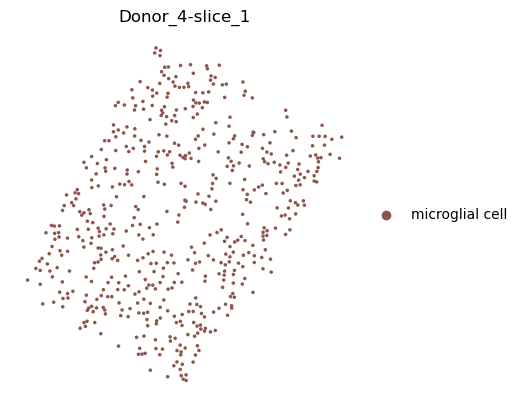

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


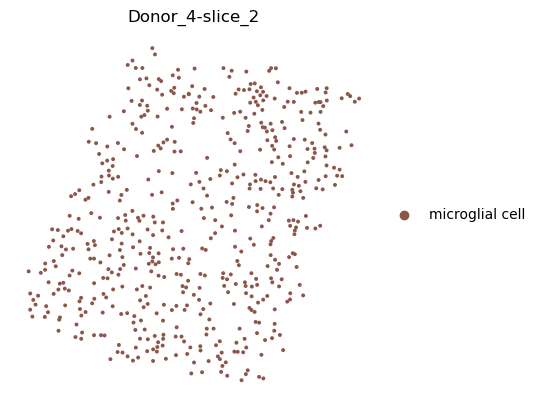

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


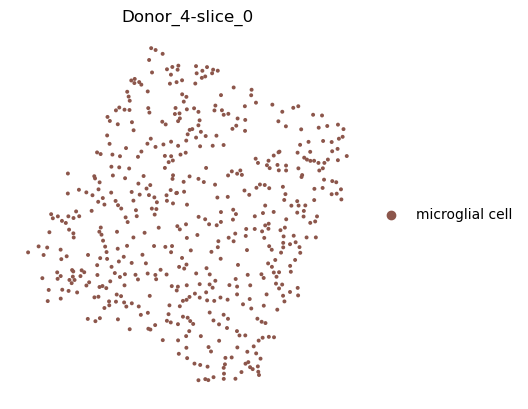

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


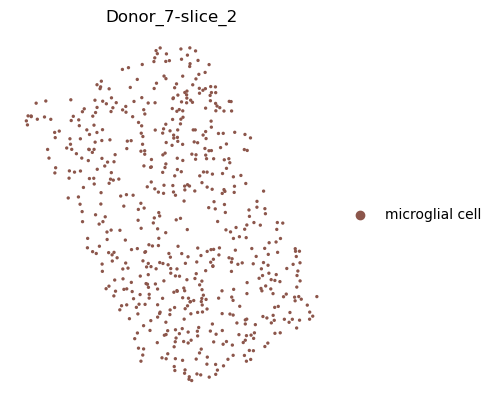

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


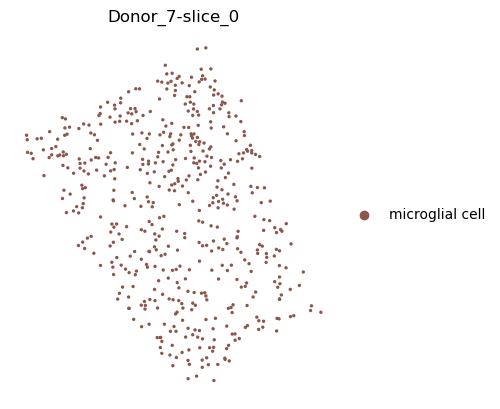

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


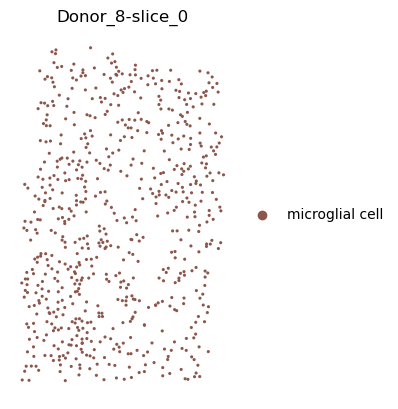

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


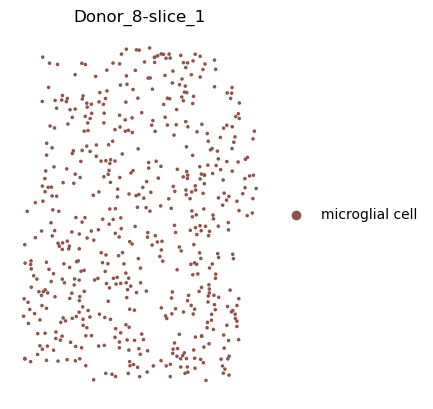

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


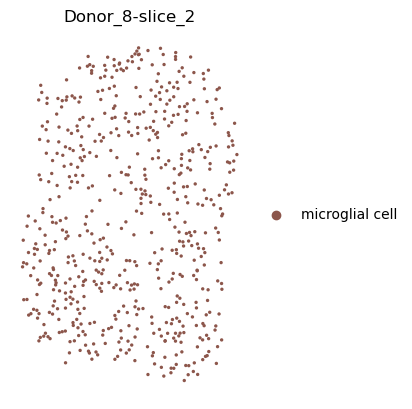

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


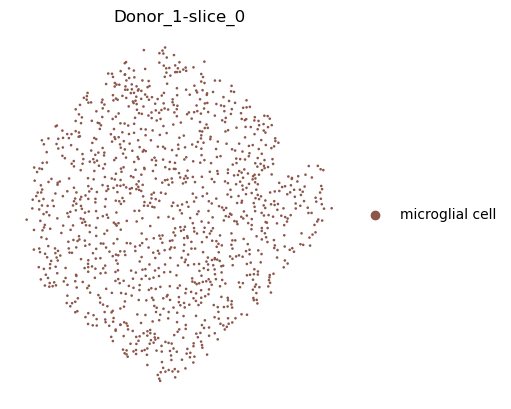

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


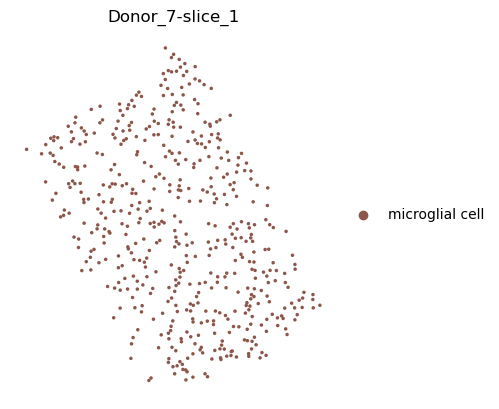

In [100]:
# Niche1 = neuron
# Niche2 = medium spiny neuron
# Niche3 = astrocyte
# Niche4 = oligodendrocyte
# Niche5 = microglia

cell_types = ["microglial cell"]

for sample in adata.obs.donor_slice.unique().tolist()[:]:
    sc.pl.spatial(
        adata=adata[
            adata.obs["cell_type"].isin(cell_types)
            & (adata.obs["donor_slice"] == sample)
        ],
        spot_size=40,
        color=["cell_type"],
        ncols=2,
        frameon=False,
        title=sample,
    )

In [101]:
cell_types = adata.obs.cell_type.unique().tolist()
int_to_cell_type = {i: cell_types[i] for i in range(len(cell_types))}
int_to_cell_type

{0: 'endothelial cell',
 1: 'oligodendrocyte precursor cell',
 2: 'neuron',
 3: 'astrocyte',
 4: 'inhibitory interneuron',
 5: 'pericyte',
 6: 'oligodendrocyte',
 7: 'microglial cell',
 8: 'vascular leptomeningeal cell',
 9: 'medium spiny neuron',
 10: 'macrophage',
 11: 'T cell',
 12: 'cell'}

In [72]:
# Niche1 = neuron  2
# Niche2 = medium spiny neuron  9
# Niche3 = astrocyte 3
# Niche4 = oligodendrocyte 6
# Niche5 = microglia 7

In [145]:
# filter rows that have adata.obsm['neighborhood_composition'] column index 2 > 0.2 and retrieve the row indexes:

treshold = 0.3333

cell_type_index = 2
cell_type = int_to_cell_type[cell_type_index]

niches = [2, 3, 6, 9]

neighborhood_composition_niches = neighborhood_composition.iloc[:, niches]

for cell_type_index in niches:
    cell_type = int_to_cell_type[cell_type_index]
    adata.obs.niche_type[
        adata.obsm["neighborhood_composition"][:, cell_type_index] > treshold
    ] = cell_type

/tmp/ipykernel_1584113/2647571555.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.niche_type[adata.obsm["neighborhood_composition"][:, cell_type_index] > treshold] = cell_type


In [107]:
adata.obs.niche_type.value_counts()

niche_type
neuron                 39008
unknown                34948
medium spiny neuron    31317
oligodendrocyte        13448
astrocyte               4911
Name: count, dtype: int64

In [175]:
niche_types = adata.obs.niche_type.unique().tolist()
niche_types

['neuron', 'unknown', 'oligodendrocyte', 'astrocyte', 'medium spiny neuron']

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


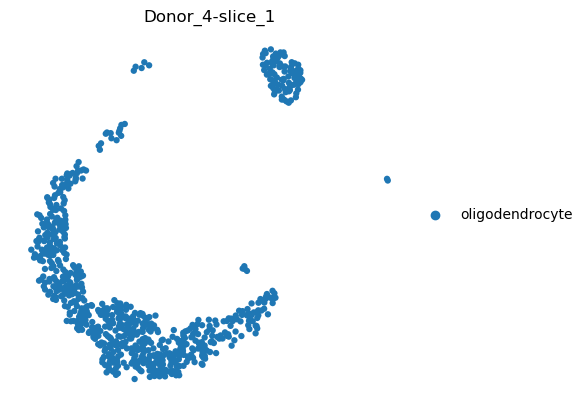

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


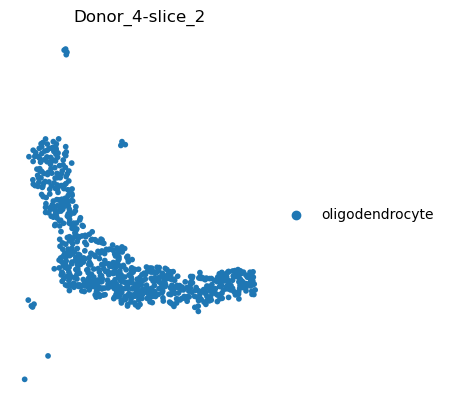

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


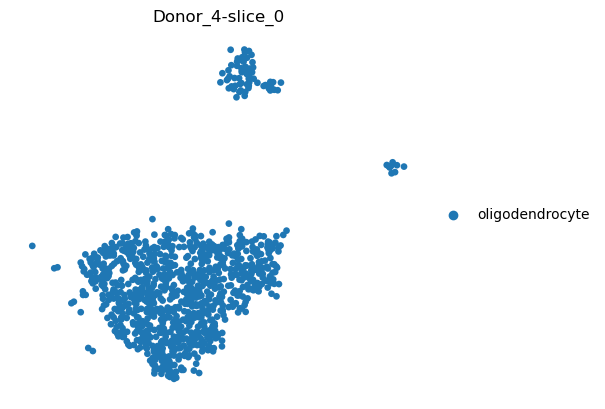

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


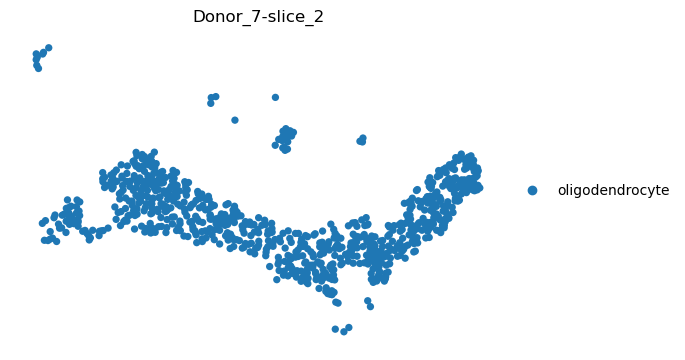

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


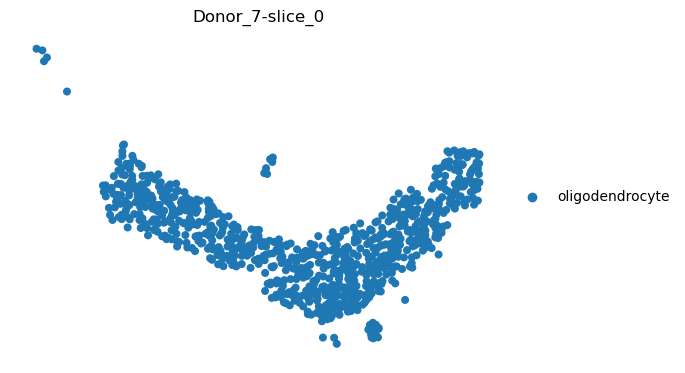

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


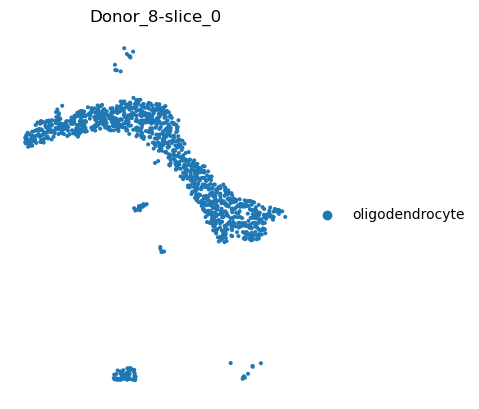

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


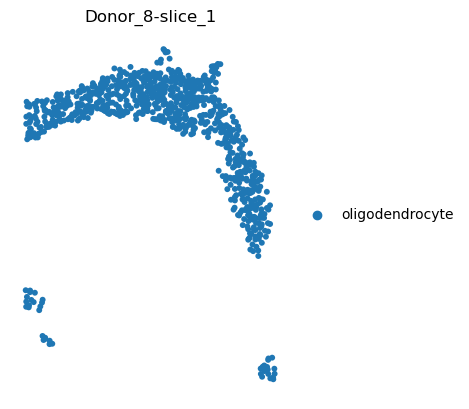

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


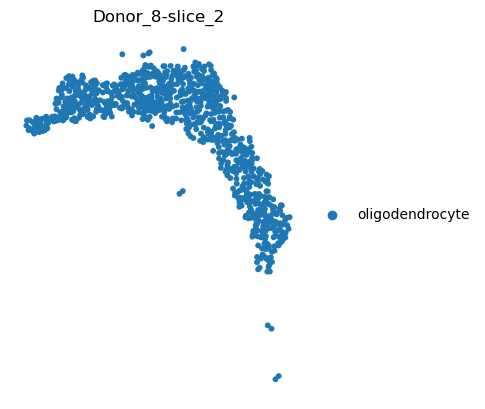

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


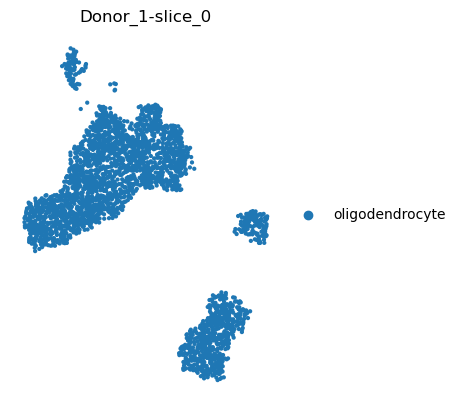

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


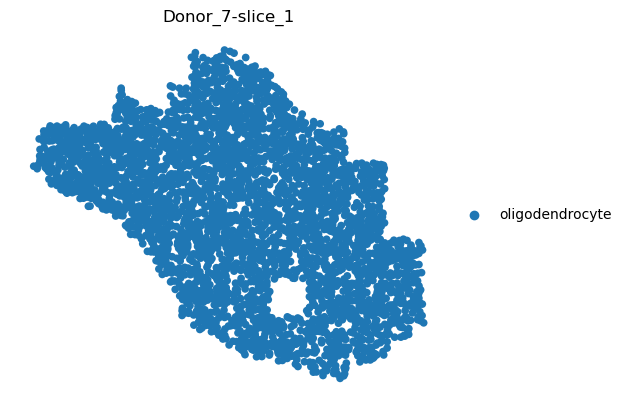

In [109]:
for sample in adata.obs.donor_slice.unique().tolist()[:]:
    sc.pl.spatial(
        adata=adata[
            adata.obs["niche_type"].isin(["oligodendrocyte"])
            & (adata.obs["donor_slice"] == sample)
        ],
        spot_size=40,
        color=["niche_type"],
        ncols=1,
        frameon=False,
        title=sample,
    )

In [121]:
# Define the threshold
threshold = 0.3333

# Check which values are greater than the threshold
greater_than_threshold = adata.obsm["neighborhood_composition"][:, niches] > threshold

# Sum the True values in each row (axis=1) to count the number of values greater than the threshold
count_greater = np.sum(greater_than_threshold, axis=1)

# Get the value counts for the counts
value_counts = np.bincount(count_greater)

value_counts

array([34948, 87720,   964])

In [123]:
neighborhood_composition.iloc[:, niches][count_greater == 2]

,neuron,astrocyte,oligodendrocyte,medium spiny neuron
1010,0.350000,0.000000,0.450000,0.0
1014,0.380952,0.047619,0.333333,0.0
1018,0.333333,0.047619,0.380952,0.0
1026,0.428571,0.047619,0.333333,0.0
1052,0.521739,0.043478,0.347826,0.0
...,...,...,...,...
121503,0.043478,0.347826,0.434783,0.0
121525,0.047619,0.333333,0.476190,0.0
122028,0.043478,0.391304,0.347826,0.0
122034,0.050000,0.350000,0.500000,0.0


In [190]:
neighborhood_composition = pd.DataFrame(
    adata.obsm["neighborhood_composition"], columns=cell_types
)
neighborhood_composition_niches = neighborhood_composition.iloc[:, niches]

max_ct = neighborhood_composition_niches.max(axis=1)

df = neighborhood_composition_niches  #.copy()

# Create a new column with the name of the column containing the maximum value for each row
df["niche_assignment"] = df.idxmax(axis=1)

# Set 'max_column' to 'unknown' for rows where the maximum value is less than the threshold
df.loc[max_ct < 0.2, "niche_assignment"] = "unknown"

/tmp/ipykernel_1584113/2154981468.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["niche_assignment"] = df.idxmax(axis=1)


In [191]:
df["niche_assignment"].value_counts()

niche_assignment
neuron                 42502
medium spiny neuron    31410
unknown                24769
oligodendrocyte        14529
astrocyte              10422
Name: count, dtype: int64

In [184]:
def get_cell_niches(
    adata: AnnData,
    cell_types_to_include: list[str],
    treshold: float = 0.2,
    niche_type_key: str = "niche_type",
    niche_composition_key: str = "niche_composition",
):
    composition_subet = neighborhood_composition[cell_types_to_include]

    # for each cell, get the cell type with the highest proportion in its neighborhood

    max_ct = composition_subet.max(axis=1)

    # Create a new column with the name of the column containing the maximum value for each row
    composition_subet["niche_assignment"] = composition_subet.idxmax(axis=1)

    # Set 'max_column' to 'unknown' for rows where the maximum value is less than the threshold
    composition_subet.loc[max_ct < treshold, "niche_assignment"] = "unknown"

    adata.obs[niche_type_key] = composition_subet["niche_assignment"].values

    return None

In [185]:
get_cell_niches(adata, cell_types_to_include=['neuron', 'oligodendrocyte', 'astrocyte', 'medium spiny neuron'], niche_composition_key='neighborhood_composition')

/tmp/ipykernel_1584113/3149659337.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  composition_subet["niche_assignment"] = composition_subet.idxmax(axis=1)


In [186]:
adata.obs['niche_type'].value_counts()

niche_type
neuron                 42502
medium spiny neuron    31410
unknown                24769
oligodendrocyte        14731
astrocyte              10220
Name: count, dtype: int64